# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 2 minutes

This notebook demonstrates the ease with which [PyBEL](http://pybel.readthedocs.io) can be used to parse BEL scripts and work with other formats for biological knowledge assembly models. It further demonstrates how its sister package, [PyBEL Tools](http://pybel-tools.readthedocs.io) can be used to visualize and explore the Alzheimer's Disease (AD) knowledge assembly model that has been annotated with the [NeuromMMSig Database](http://neurommsig.scai.fraunhofer.de/pathways/introduction) to gain further mechanistic insight.

### Notebook Setup

In [1]:
import logging
import os
import sys
import time
from collections import Counter, defaultdict
from operator import itemgetter

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

import pybel
import pybel_tools as pbt
from pybel.constants import *
from pybel_tools.visualization import to_jupyter
from pybel_tools.utils import barh, barv

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
logging.basicConfig(level=20)

### Notebook Provenance

The time of execution and the versions of the software packegs used are displayed explicitly.

In [4]:
time.asctime()

'Mon Apr 24 13:39:06 2017'

In [5]:
pybel.__version__

'0.5.3'

In [6]:
pbt.__version__

'0.1.8-dev'

### Local Path Definitions

To make this notebook interoperable across many machines, locations to the repositories that contain the data used in this notebook are referenced from the environment, set in `~/.bashrc` to point to the place where the repositories have been cloned. Assuming the repositories have been `git clone`'d into the `~/dev` folder, the entries in `~/.bashrc` should look like:

```bash
...
export BMS_BASE=~/dev/bms
export BANANA_BASE=~/dev/banana
...
```

#### BMS 

The biological model store (BMS) is the internal Fraunhofer SCAI repository for keeping BEL models under version control. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/bms/

In [7]:
bms_base = os.environ["BMS_BASE"]

#### BANANA

Project BANANA contains data sets and analytical pipelines from the NeuroAllianz and D10 projects intended for algorithm development. It can be downloaded from https://tor-2.scai.fraunhofer.de/gf/project/banana

In [8]:
banana_base = os.environ["BANANA_BASE"]

# Alzheimer's Disease Knowledge Assembly

## Loading

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [9]:
pickle_path = os.path.join(bms_base, "aetionomy", "alzheimers", "alzheimers.gpickle")

In [10]:
graph = pybel.from_pickle(pickle_path)

In [11]:
graph.version

'3.0.2'

In [12]:
# Add all canonical names for later
pbt.mutation.add_canonical_names(graph)

## Contents Summary

A summary of the types of nodes and edges is output using `matplotlib` and [pbt.summary.plot_summary](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.plot_summary). It is displayed with beautiful vector graphics using a tweak at the beginning of the notebook: `%config InlineBackend.figure_format = 'svg'` 

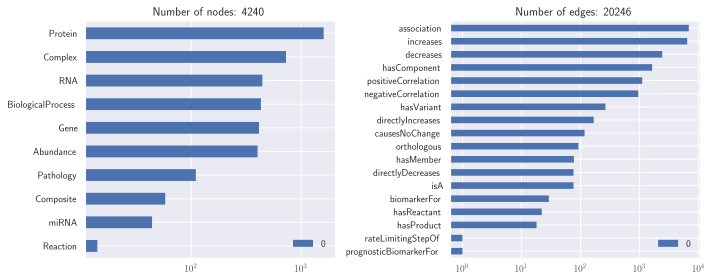

In [13]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

A summary of the namespaces used in the network can provide insight to the types of articles used. For example, it's good to know that a graph consists of many nodes from literature on Human, Mouse, and Rat. This can be produced with [pbt.summary.count_namespaces](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_namespaces) and plotted with `matplotlib`. PyBEL Tools also provides a wrapper for plotting the `Counter` objects returned by many of its functions with [pbt.utils.barh](http://pybel-tools.readthedocs.io/en/latest/utilities.html#pybel_tools.utils.barh) and [pbt.utils.barv](http://pybel-tools.readthedocs.io/en/latest/utilities.html#pybel_tools.utils.barv).


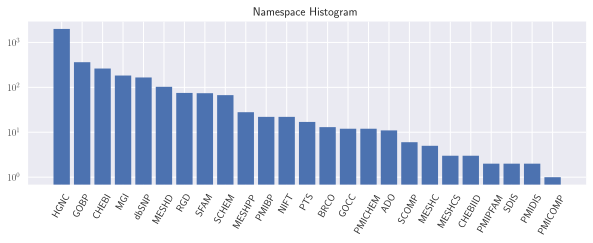

In [14]:
namespace_counter = pbt.summary.count_namespaces(graph)

plt.figure(figsize=(10, 3))
barv(namespace_counter, plt, "Namespace Histogram", rotation=60)
plt.yscale("log")

Immediately, the MGI and RGD nodes should be discarded using the in-place mutation function [pbt.mutation.remove_nodes_by_namespace](http://pybel-tools.readthedocs.io/en/latest/mutation.html#pybel_tools.mutation.remove_nodes_by_namespace).

In [15]:
pbt.filters.remove_nodes_by_namespace(graph, "MGI")
pbt.filters.remove_nodes_by_namespace(graph, "RGD")

Likewise, a histogram of the usage of annotations in the network calculated with [pbt.summary.count_annotations](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_annotations) can quickly summarize the information content contained within the graph.

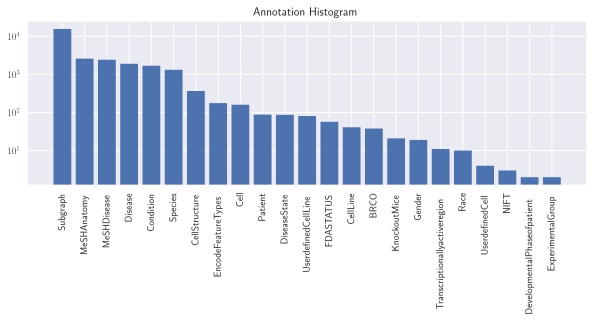

In [16]:
annotation_counter = pbt.summary.count_annotations(graph)

# Problem with encoding underscores in latex. Disregard this
annotation_counter = {k.replace("_", ""): v for k, v in annotation_counter.items()}

plt.figure(figsize=(10, 3))
barv(annotation_counter, plt, "Annotation Histogram")
plt.yscale("log")

The NeuroMMSig Database, the largest mechanism inventory related to Alzheimer's and Parkinson's Disease, has been pre-annotated to the knowledge assembly. Many functions have been written to extract information about the logical subgraphs underlying these mechanisms.

The function [pbt.summary.count_annotation_values](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.count_annotation_values) is used to count the number of edges in each Subgraph. Below is output the total number of unique Subgraphs:

In [17]:
subgraph_counter = pbt.summary.count_annotation_values(graph, "Subgraph")

len(subgraph_counter)

126

The counts are examined closer by outputting the top 30 biggest subgraphs with their sizes as a bar plot.

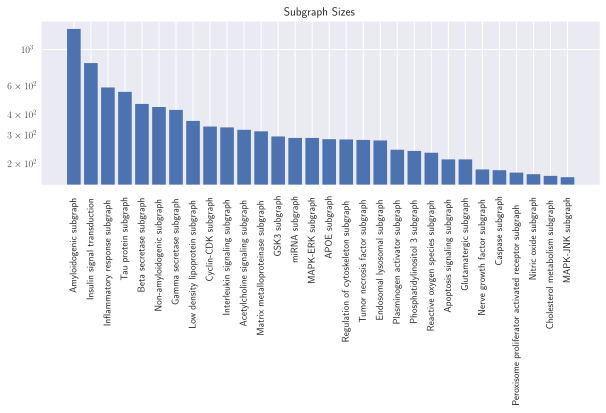

In [18]:
top_subgraph_counter = dict(subgraph_counter.most_common(30))

plt.figure(figsize=(10, 3))
barv(top_subgraph_counter, plt, "Subgraph Sizes")
plt.yscale("log")

A subgraph can be easily selected with [pbt.selection.get_subgraph_by_annotation_value](http://pybel-tools.readthedocs.io/en/latest/selection.html#pybel_tools.selection.get_subgraph_by_annotation_value). In this example, the GABA subgraph is used. A simple summary of the subgraph can be printed with [pbt.summary.print_summary](http://pybel-tools.readthedocs.io/en/latest/summary.html#pybel_tools.summary.print_summary)

In [19]:
example_subgraph_name = "GABA subgraph"

In [20]:
subgraph = pbt.selection.get_subgraph_by_annotation_value(
    graph, annotation="Subgraph", value=example_subgraph_name
)

pbt.summary.print_summary(subgraph)

Number of nodes: 60
Number of edges: 152
Network density: 0.04293785310734463
Number weakly connected components: 7
Average in-degree: 2.533333333333333
Average out-degree: 2.533333333333333


The best way to explore a subgraph is when displayed as a subgraph. A module for outputting an interactive visualization directly in a Jupyter Notebook is built in to [pbt.visualization.to_jupyter](http://pybel-tools.readthedocs.io/en/latest/visualization.html#pybel_tools.visualization.to_jupyter)

In [21]:
to_jupyter(subgraph)

<IPython.core.display.Javascript object>

Further investigation can be done on the graph by prioritizing nodes by betweenness centrality. The top 25 most central nodes are selected.

In [22]:
node_centrality = nx.betweenness_centrality(subgraph, normalized=True)

nodes = sorted(node_centrality.items(), key=itemgetter(1), reverse=True)

for node, centrality in nodes[:25]:
    print("{:60} {}".format(str(node), centrality))

('Protein', 'HGNC', 'EGR1')                                  0.17153711279953243
('BiologicalProcess', 'GOBP', 'regulation of synaptic plasticity') 0.04704850964348334
('Pathology', 'MESHD', 'Alzheimer Disease')                  0.02396259497369959
('Protein', 'HGNC', 'GABRA1')                                0.016927665280022007
('Protein', 'HGNC', 'GABRA6')                                0.008745315776807507
('Protein', 'HGNC', 'PSEN2')                                 0.008182349503214493
('Protein', 'HGNC', 'GABRA2')                                0.000562966273593014
('Protein', 'HGNC', 'GABRA3')                                0.000562966273593014
('Protein', 'HGNC', 'GABRA4')                                0.000562966273593014
('Protein', 'HGNC', 'GABRA5')                                0.000562966273593014
('Protein', 'HGNC', 'GABRB1')                                0.000562966273593014
('Protein', 'HGNC', 'GABRB2')                                0.000562966273593014
('Protein', '

# Conclusions

PyBEL and PyBEL Tools have a wide range of functions and workflows for analyzing. While PyBEL is itself an incredibly complicated package, its user interface is very simple and straightforwards. PyBEL Tools contains other modules for analyzing the errors in a BEL script, for integrating orthology and equivalence information, and for evaluating the correctness of a network based on a "biological grammar"

See the documentation at https://pybel.readthedocs.io and https://pybel-tools.readthedocs.io for more, specific examples.